In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

tf.random.set_seed(42)
np.random.seed(42)


In [2]:
x1 = np.random.rand(4000)*10
x2 = np.random.rand(4000)*10
x3 = np.random.rand(4000)*10

x1_int = x1.astype(int) - 5
x2_int = x2.astype(int) - 5
x3_int = x3.astype(int) - 5

x1_str = x1_int.astype(str)
x2_str = x2_int.astype(str)
x3_str = x3_int.astype(str)

unique_expressions = set()

for i in range(len(x1)):
  n = np.random.rand(1)
  if n < 0.25:
    opp1 = " + "
    opp2 = " + "
  elif n > 0.25 and n < 0.5:
    opp1 = " + "
    opp2 = " - "
  elif n > 0.75:
    opp1 = " - "
    opp2 = " + "
  else:
    opp1 = " - "
    opp2 = " - "
  unique_expressions.add(x1_str[i] + opp1 + x2_str[i] + opp2 + x3_str[i])

x = list(unique_expressions) # Convert the set back to a list
print(x[0])
print(len(x))

1 + -1 - -1
2543


In [3]:
y = []

for expression in x:
  result = float(eval(expression))
  y.append(result)

print(y[0])

1.0


In [4]:
def tokenizer(input_list): # Changed parameter name to avoid confusion with global x
  #tokenizer by hand
  #tokens = (len(input_list), 5)
  # Create a copy of the input list to avoid modifying the original
  tokenized_x = [expression.split(" ") for expression in input_list]


  for i in range(len(tokenized_x)):
    for j in range(len(tokenized_x[i])):
      if j % 2 == 0:  # Check if the index is even
        tokenized_x[i][j] = np.float32(tokenized_x[i][j])
      else:  # The index is uneven, it's an operator
        if tokenized_x[i][j] == "+":
          tokenized_x[i][j] = np.float32(1)
        else:
          tokenized_x[i][j] = np.float32(0)
    padding_count = 15 - len(tokenized_x[i])
    for _ in range(padding_count): # Use a throwaway variable
      tokenized_x[i].append(np.float32(0.5))
  tokenized_x = np.array(tokenized_x)
  return tokenized_x
x = tokenizer(x)

In [5]:
# Generate all possible expressions
all_possible_expressions = set()
for num1 in range(-5, 5): # Range -5 to 4
    for num2 in range(-5, 5): # Range -5 to 4
        for num3 in range(-5, 5): # Range -5 to 4
            for op1 in [" + ", " - "]:
                for op2 in [" + ", " - "]:
                    expression = str(num1) + op1 + str(num2) + op2 + str(num3)
                    all_possible_expressions.add(expression)

# Find expressions not in x
expressions_not_in_x = all_possible_expressions - unique_expressions
expressions_not_in_x = list(expressions_not_in_x)
print("\nExpressions not in x:")
print(expressions_not_in_x[0]) # Convert back to a list for printing
if len(expressions_not_in_x)+len(x) == 4000: print(True)
print(len(expressions_not_in_x))

x_test = np.array(tokenizer(expressions_not_in_x))

y_test = []
for expression in expressions_not_in_x:
    y_test.append(float(eval(expression)))

print(y_test[0])


Expressions not in x:
2 - 4 + -5
True
1457
-7.0


In [6]:
#a list of expressions outside the number range
outsideExpr = set()
range1= range(5, 9)
range2= range(-8, -4)
comboRange = list(range1) + list(range2)
for num1 in comboRange:
    for num2 in comboRange:
        for num3 in comboRange:
            for op1 in [" + ", " - "]:
                for op2 in [" + ", " - "]:
                    expression = str(num1) + op1 + str(num2) + op2 + str(num3)
                    outsideExpr.add(expression)

outsideExpr = list(outsideExpr)
print(len(tokenizer(outsideExpr)[0]))

out_x_test = tokenizer(outsideExpr)
out_y_test = []
for i in outsideExpr:
  result = float(eval(i))
  out_y_test.append(result)

15


In [7]:
minNums = 2
maxNums = 8
amountNums = 100
num_terms = np.arange(minNums-1,maxNums)
longer_Exps = []
for j in num_terms:
  for p in range(amountNums):
    longer_Exp = ""
    for i in range(j):
      longer_Exp += str(np.random.randint(-5,6))
      longer_Exp += np.random.choice([" + ", " - "])
    longer_Exp += str(np.random.randint(-5,6))
    longer_Exps.append(longer_Exp)

longer_Exps = list(longer_Exps)
long_x_test = tokenizer(longer_Exps)
long_y_test = []
for i in longer_Exps:
  result = float(eval(i))
  long_y_test.append(result)
print(long_y_test[0])
print(long_x_test[0])

-4.0
[-5.   1.   1.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5]


In [8]:
x_train, x_val, y_train, y_val = \
    train_test_split(x, y, train_size=0.75)
x_train, x_val, y_train, y_val = \
    np.array(x_train), np.array(x_val), np.array(y_train), np.array(y_val)


In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='mse',
    mode = "min"
)

In [10]:
def create_basemodel(input_shape):
    model = keras.Sequential([
        keras.Input(shape=(input_shape, 1)),
        keras.layers.SimpleRNN(50, return_sequences=True),
        keras.layers.PReLU(),
        keras.layers.SimpleRNN(50),
        keras.layers.PReLU(),
        keras.layers.Dense(1, activation = "linear")
    ])
    return model

In [11]:
n_bootstrap = 1
bootstrap_predsInRange = []
bootstrap_predsOutRange = []
bootstrap_predsLongRange = []

for _ in range(n_bootstrap):
    # Create bootstrap sample
    sample_indices1 = np.random.choice(len(x_train), size=len(x_train), replace=True)
    sample_indices2 = np.random.choice(len(x_val), size=len(x_val), replace=True)
    x_train_bootstrap = x_train[sample_indices1]
    y_train_bootstrap = y_train[sample_indices1]
    x_val_bootstrap = x_val[sample_indices2]
    y_val_bootstrap = y_val[sample_indices2]
    
    bootstrap_model = create_basemodel(len(x_train[0]))

    bootstrap_model.compile(optimizer = "adam", loss = "mse", metrics=['mse'])

    bootstrap_train_dataset = tf.data.Dataset.from_tensor_slices((x_train_bootstrap, y_train_bootstrap)).batch(32)
    bootstrap_val_dataset = tf.data.Dataset.from_tensor_slices((x_val_bootstrap, y_val_bootstrap)).batch(32)
    bootstrap_model.fit(
    bootstrap_train_dataset,
    validation_data = bootstrap_val_dataset,
    epochs=200,
    verbose=1, # Suppress output
    callbacks=[early_stopping]
    )
    bootstrap_predsInRange.append(bootstrap_model.predict(x_test))
    bootstrap_predsOutRange.append(bootstrap_model.predict(out_x_test))
    bootstrap_predsLongRange.append(bootstrap_model.predict(long_x_test))
    
bootstrap_model.summary()

    

2025-10-02 22:27:42.915856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-02 22:27:42.969511: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-02 22:27:42.969698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-02 22:27:42.972295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-02 22:27:42.972498: I external/local_xla/xla/stream_executor

Epoch 1/200


I0000 00:00:1759436868.224355  372602 service.cc:145] XLA service 0xfffe58004b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759436868.224438  372602 service.cc:153]   StreamExecutor device (0): Orin, Compute Capability 8.7
2025-10-02 22:27:48.319295: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-02 22:27:48.755884: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90300


 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23.6353 - mse: 23.6353

I0000 00:00:1759436869.761406  372602 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 20.6850 - mse: 20.6850 - val_loss: 16.2365 - val_mse: 16.2365
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 12.9918 - mse: 12.9918 - val_loss: 8.9035 - val_mse: 8.9035
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3569 - mse: 6.3569 - val_loss: 3.9059 - val_mse: 3.9059
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.1456 - mse: 3.1456 - val_loss: 2.7732 - val_mse: 2.7732
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2732 - mse: 2.2732 - val_loss: 2.0840 - val_mse: 2.0840
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4481 - mse: 1.4481 - val_loss: 1.3767 - val_mse: 1.3767
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0291 - mse: 1.0291 - val_loss: 0.9721 - val_mse: 0.9721
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7898 - mse: 0.7898 - val_loss: 0.8478 - val_mse: 0.8478
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 15, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 15, 50)         │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 50)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,505 (99.63 KB)

 Trainable params: 8,501 (33.21 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,004 (66.43 KB)

In [12]:
predsInRange = []
for i in range(len(x_test)):
    calc = 0
    for j in range(n_bootstrap):
        calc += bootstrap_predsInRange[j][i]
    predsInRange.append(calc/n_bootstrap)


In [13]:
predsOutRange = []
for i in range(len(out_x_test)):
    calc = 0
    for j in range(n_bootstrap):
        calc += bootstrap_predsOutRange[j][i]
    predsOutRange.append(calc/n_bootstrap)


In [14]:
predsLongRange = []
for i in range(len(long_x_test)):
    calc = 0
    for j in range(n_bootstrap):
        calc += bootstrap_predsLongRange[j][i]
    predsLongRange.append(calc/n_bootstrap)


In [15]:
differences = []
relativeError = []
out_differences = []
out_relativeError = []

for i in range(len(predsInRange)):
    differences.append(abs(predsInRange[i]-y_test[i]))
print(np.mean(differences))
avDifference = np.mean(differences)

for i in range(len(y_test)):
  if y_test[i] != 0:
    relativeError.append(differences[i]/abs(y_test[i]))
  else:
    relativeError.append(differences[i])
print(np.mean(relativeError))
avRelError = np.mean(relativeError)

for i in range(len(predsOutRange)):
    out_differences.append(abs(predsOutRange[i]-out_y_test[i]))
print(np.mean(out_differences))
av_out_Difference = np.mean(out_differences)

for i in range(len(out_y_test)):
  if out_y_test[i] != 0:
    out_relativeError.append(out_differences[i]/abs(out_y_test[i]))
  else:
    out_relativeError.append(out_differences[i])
print(np.mean(out_relativeError))
av_out_RelError = np.mean(out_relativeError)


0.2937096
0.1297233
3.7199743
0.38568592


In [16]:
def absSum(x):
  expressions = x
  p = []
  for i in range(len(expressions)):
    components = []
    components = expressions[i].split(" ")
    p.append(abs(int(components[0])) + abs(int(components[2])) + abs(int(components[4])))
  return p

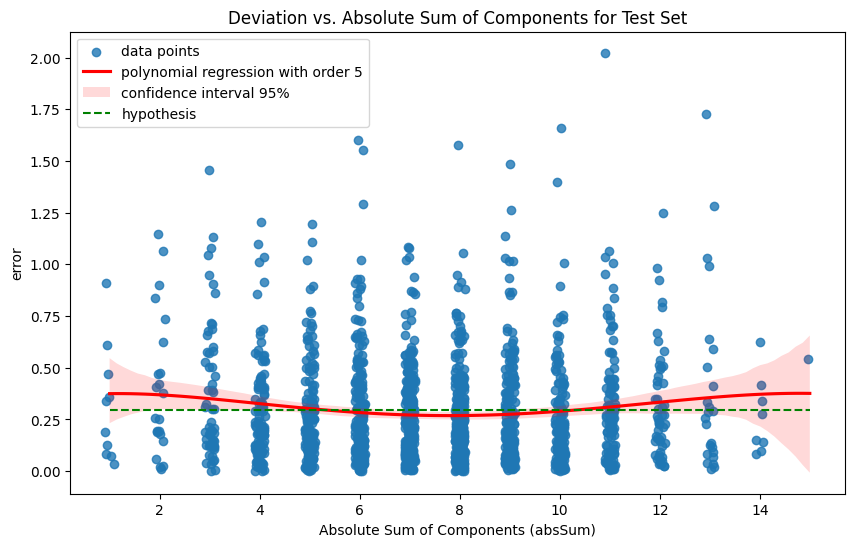

In [17]:
paired_data = sorted(zip(absSum(expressions_not_in_x), differences))

# Unpack the sorted paired_data into separate lists for plotting
sorted_abs_sum = [item[0] for item in paired_data]
sorted_deviation = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_deviation, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")

x_values = np.arange(1,16)
y_values = np.full_like(x_values, avDifference, dtype=np.float32)
plt.plot(x_values, y_values, color='green', linestyle='--', label='hypothesis')

plt.xlabel("Absolute Sum of Components (absSum)")
plt.ylabel("error")
plt.title("Deviation vs. Absolute Sum of Components for Test Set")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%", "hypothesis"])
plt.show()


0.1297233


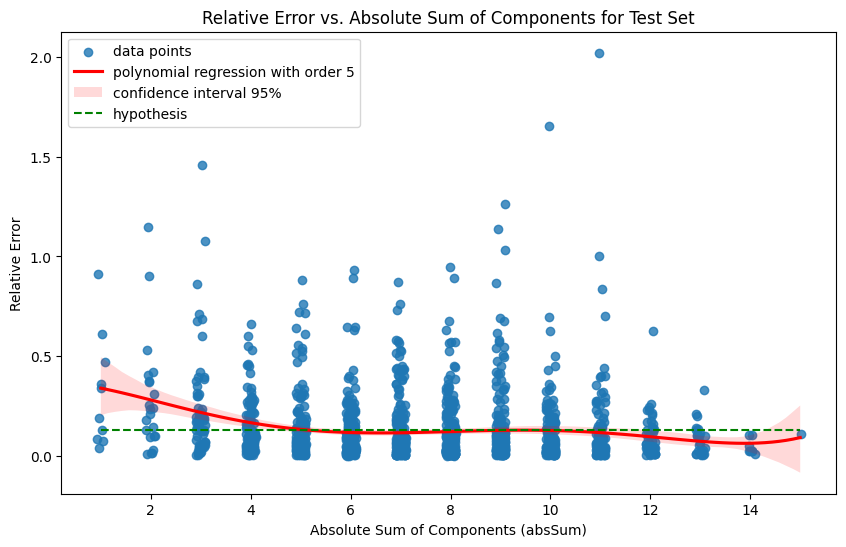

In [18]:
paired_data = sorted(zip(absSum(expressions_not_in_x), relativeError))

# Separate the sorted absSum and relativeError values
sorted_abs_sum = [item[0] for item in paired_data]
sorted_relative_error = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_relative_error, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")

x_values = np.arange(1,16)
y_values = np.full_like(x_values, np.mean(relativeError), dtype=np.float32)
plt.plot(x_values, y_values, color='green', linestyle='--', label='hypothesis')

print(np.mean(relativeError))
plt.xlabel("Absolute Sum of Components (absSum)")
plt.ylabel("Relative Error") # Changed label to reflect relativeError
plt.title("Relative Error vs. Absolute Sum of Components for Test Set")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%", "hypothesis"])
plt.show()

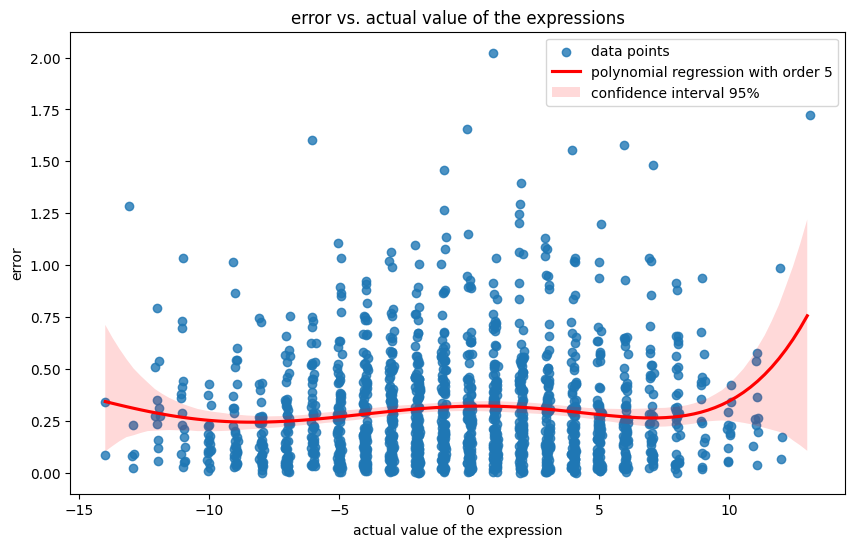

In [19]:
paired_data = sorted(zip(y_test, differences))

# Separate the sorted absSum and relativeError values
sorted_abs_sum = [item[0] for item in paired_data]
sorted_relative_error = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_relative_error, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")


plt.xlabel("actual value of the expression")
plt.ylabel("error") # Changed label to reflect relativeError
plt.title("error vs. actual value of the expressions")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%"])
plt.show()

0.1297233


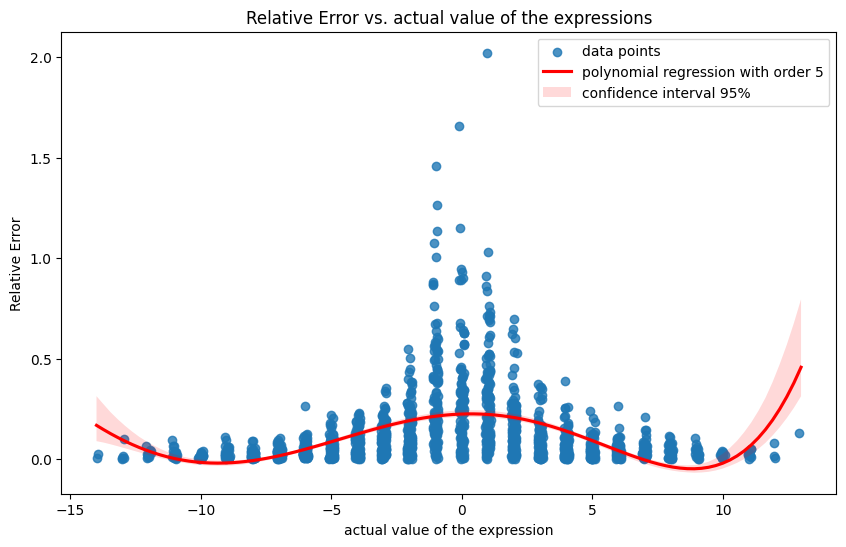

In [20]:
paired_data = sorted(zip(y_test, relativeError))

# Separate the sorted absSum and relativeError values
sorted_abs_sum = [item[0] for item in paired_data]
sorted_relative_error = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_relative_error, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")

print(np.mean(relativeError))
plt.xlabel("actual value of the expression")
plt.ylabel("Relative Error") # Changed label to reflect relativeError
plt.title("Relative Error vs. actual value of the expressions")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%"])
plt.show()

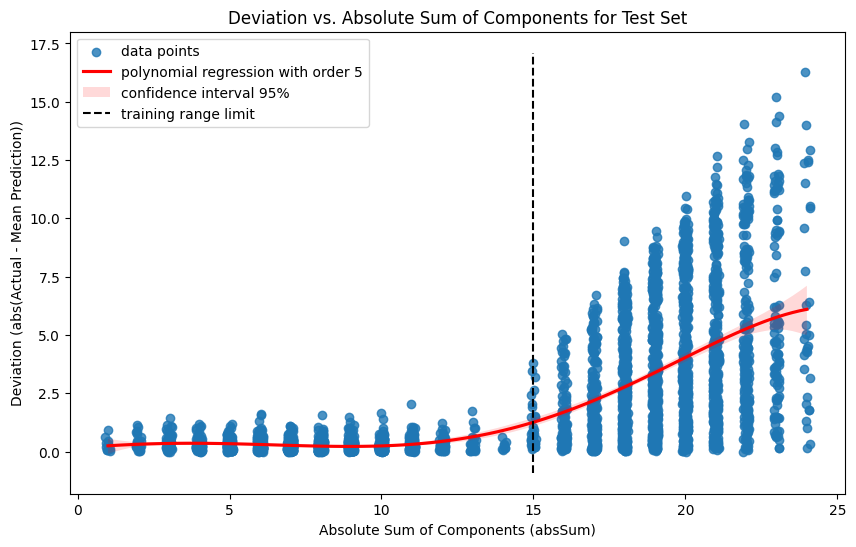

In [21]:
most_Expr =outsideExpr + expressions_not_in_x
most_deviation = out_differences + differences
most_absSum = absSum(outsideExpr) + absSum(expressions_not_in_x)

paired_data = sorted(zip(most_absSum, most_deviation))

# Separate the sorted absSum and relativeError values
sorted_abs_sum = [item[0] for item in paired_data]
sorted_relative_error = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_relative_error, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")


# Define the x-coordinate for the vertical line
vertical_line_x = 15

# Define the y-range for the vertical line (adjust as needed)
# You can use the range of your data's y-values or a specific range
# For example, to cover the range of your plotted data:
min_y = min(plt.gca().get_ylim()) # Get the current y-axis limits
max_y = max(plt.gca().get_ylim())
vertical_line_y = np.linspace(min_y, max_y, 100) # Create a range of y values

plt.plot(np.full_like(vertical_line_y, vertical_line_x), vertical_line_y, color='black', linestyle='--', label='training range limit')


plt.xlabel("Absolute Sum of Components (absSum)")
plt.ylabel("Deviation (abs(Actual - Mean Prediction))")
plt.title("Deviation vs. Absolute Sum of Components for Test Set")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%", "training range limit"])
plt.show()


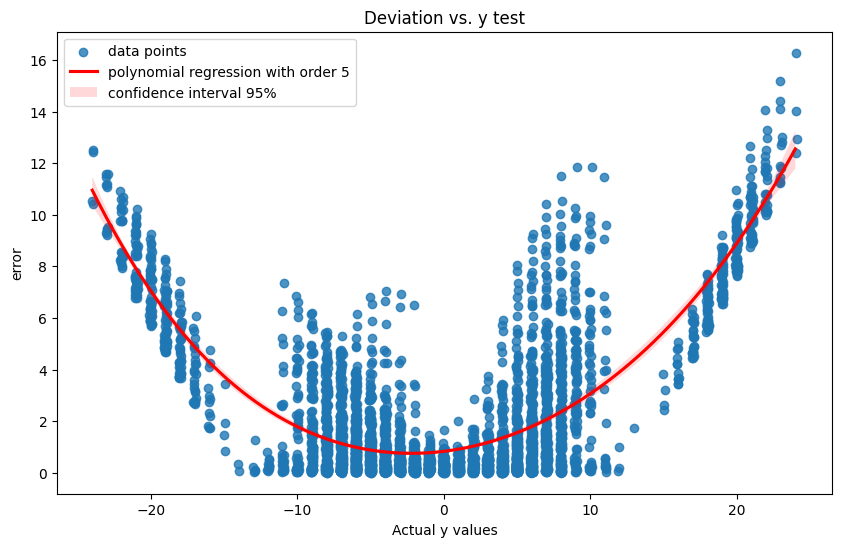

In [22]:
most_Expr =outsideExpr + expressions_not_in_x
most_deviation = out_differences + differences
most_y = out_y_test + y_test

paired_data = sorted(zip(most_y, most_deviation))

sorted_abs_sum = [item[0] for item in paired_data]
sorted_relative_error = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_relative_error, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")

plt.xlabel("Actual y values")
plt.ylabel("error")
plt.title("Deviation vs. y test")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%"])
plt.show()


0.27928433


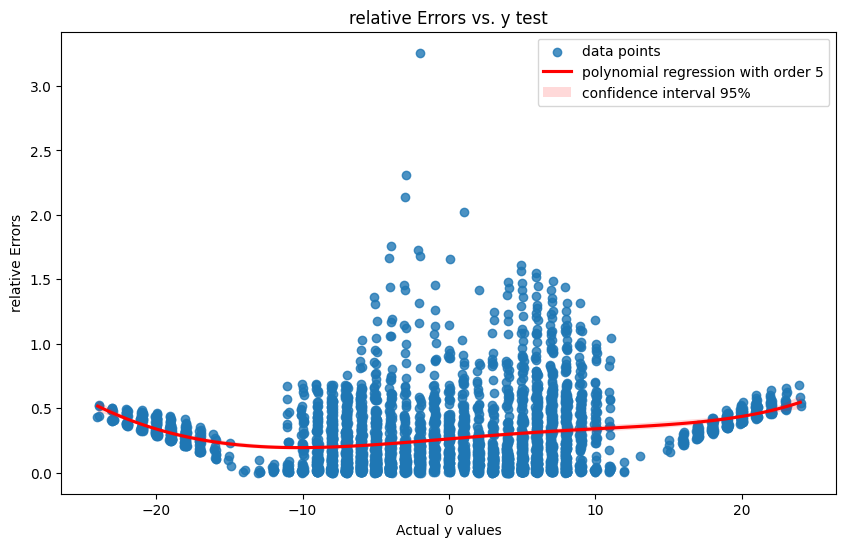

In [23]:
most_Expr =outsideExpr + expressions_not_in_x
most_deviation = out_relativeError + relativeError
most_y = out_y_test + y_test
avRelError = np.mean(most_deviation)

print(avRelError)
paired_data = sorted(zip(most_y, most_deviation))

sorted_abs_sum = [item[0] for item in paired_data]
sorted_relative_error = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_relative_error, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")

plt.xlabel("Actual y values")
plt.ylabel("relative Errors")
plt.title("relative Errors vs. y test")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%"])
plt.show()


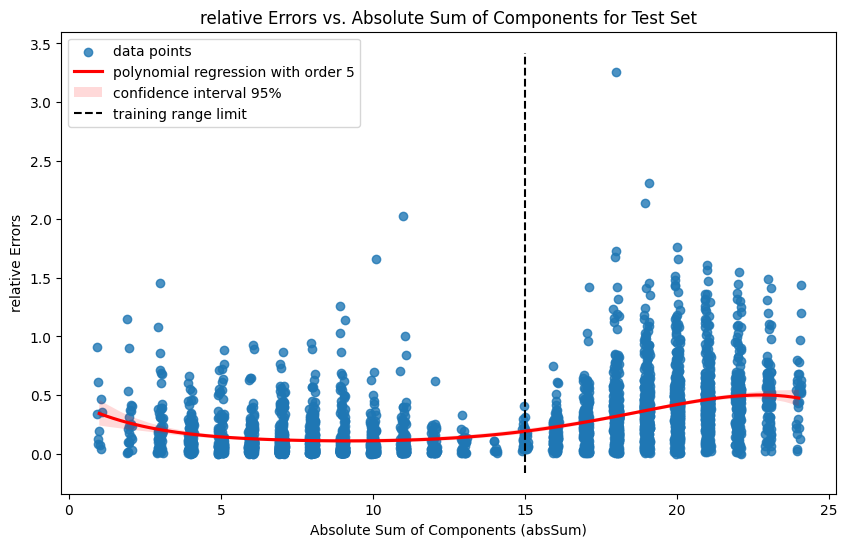

In [24]:
most_Expr =outsideExpr + expressions_not_in_x
most_deviation = out_relativeError + relativeError
most_absSum = absSum(outsideExpr) + absSum(expressions_not_in_x)

paired_data = sorted(zip(most_absSum, most_deviation))

sorted_abs_sum = [item[0] for item in paired_data]
sorted_relative_error = [item[1] for item in paired_data]

plt.figure(figsize=(10, 6))
# Use the unpacked lists for regplot
sns.regplot(x=sorted_abs_sum, y=sorted_relative_error, order = 5, x_jitter=0.1, color = "red", scatter_kws ={"color": None}, label="data points")


# Define the x-coordinate for the vertical line
vertical_line_x = 15

# Define the y-range for the vertical line (adjust as needed)
# You can use the range of your data's y-values or a specific range
# For example, to cover the range of your plotted data:
min_y = min(plt.gca().get_ylim()) # Get the current y-axis limits
max_y = max(plt.gca().get_ylim())
vertical_line_y = np.linspace(min_y, max_y, 100) # Create a range of y values

plt.plot(np.full_like(vertical_line_y, vertical_line_x), vertical_line_y, color='black', linestyle='--', label='training range limit')


plt.xlabel("Absolute Sum of Components (absSum)")
plt.ylabel("relative Errors")
plt.title("relative Errors vs. Absolute Sum of Components for Test Set")
plt.legend(["data points", "polynomial regression with order 5", "confidence interval 95%", "training range limit"])
plt.show()


700
3.7082756
700


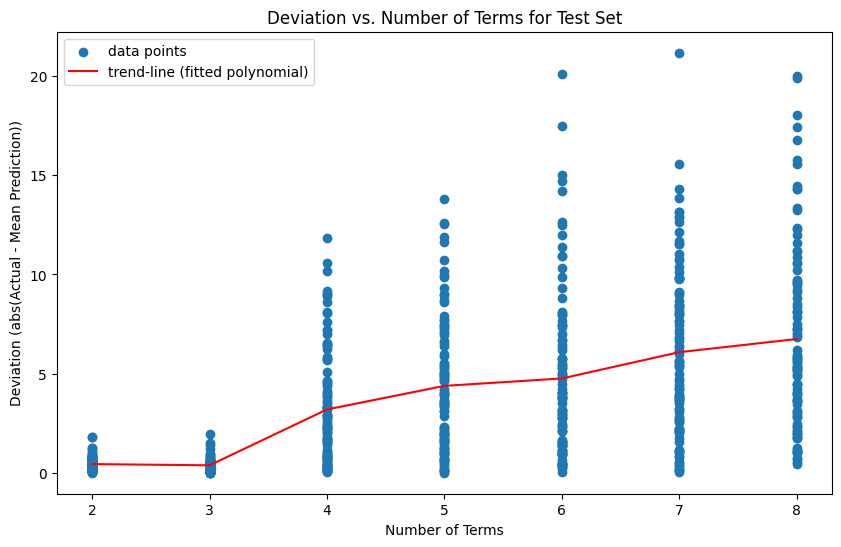

In [25]:
long_deviation = []
for i in range(len(predsLongRange)): long_deviation.append(abs(predsLongRange[i] - long_y_test[i]))
print(len(long_deviation))
print(np.mean(long_deviation))

repeated_integers = []
for i in range(minNums, maxNums + 1):
  repeated_integers.extend([i] * amountNums)
print(len(long_deviation))
repeated_integers = np.array(repeated_integers)

long_coef = np.polyfit(repeated_integers, long_deviation, 5)


plt.figure(figsize=(10, 6))
plt.scatter(repeated_integers, long_deviation,  label = "data points")
plt.plot(repeated_integers, np.polyval(long_coef, repeated_integers), color='red', label=("trend-line (fitted polynomial)"))
plt.xlabel("Number of Terms")
plt.ylabel("Deviation (abs(Actual - Mean Prediction))")
plt.title("Deviation vs. Number of Terms for Test Set")
plt.legend()
plt.show()

In [28]:
import sys
import os

# Get the absolute path of the current script's directory
current_dir = os.path.dirname(os.path.abspath("transformer0.ipynb"))

# Get the absolute path of the parent directory (project_folder)
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the Python path
sys.path.append(parent_dir)

from FNN1_1 import baseline_deviation, baeline_out_deviation, baseline_long_deviation, baseline_relError, absSum
baseline_out_deviation = baeline_out_deviation

Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 19.9664 - val_loss: 15.7883
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.7071 - val_loss: 15.0268
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.7501 - val_loss: 13.9703
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.5173 - val_loss: 12.5882
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.8590 - val_loss: 10.6956
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6731 - val_loss: 8.2426
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0024 - val_loss: 5.4817
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2463 - val_loss: 3.0293
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2719 - val_loss: 1.6197
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3502 - val_loss: 1.1011
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0193 - val_loss: 0.8968
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/capybara/Desktop/matura_project_python/github/matura/FNN1_1.py:246: RuntimeWarning: divide by zero encountered in divide
  relativeError = np.where(np.array(y_test) != 0, deviation.flatten() / np.abs(np.array(y_test)), deviation.flatten())


In [29]:
placeholder = absSum(outsideExpr)
diffOutRange = []
indices_with_placeholder_22 = [i for i, val in enumerate(placeholder) if val == 22] 

for i in indices_with_placeholder_22:
    diffOutRange.append(np.abs(out_y_test[i]-predsOutRange[i]))

diffLongRange = []
for i in range(200, 300):
    diffLongRange.append(np.array(np.abs(long_y_test[i]) - np.array(predsInRange[i])))

In [30]:
meanDiff_InRange = avDifference
meanDiff_OutRange = np.mean(diffOutRange)
meanDiff_LongRange = np.mean(diffLongRange)
meanDiff_OutRelRange = av_out_RelError

In [31]:
benchmark = 0
benchmark += baseline_deviation / (meanDiff_InRange**2) / 4
print(baseline_deviation / (meanDiff_InRange**2) / 4)

benchmark += baseline_out_deviation / (meanDiff_OutRange**2) / 4
print(baseline_out_deviation / (meanDiff_OutRange**2) / 4)

benchmark += baseline_long_deviation / (meanDiff_LongRange**2) / 4
print(baseline_long_deviation / (meanDiff_LongRange**2) / 4)

benchmark += baseline_relError / (meanDiff_OutRelRange**2) / 4
print(baseline_relError / (meanDiff_OutRelRange**2) / 4)

print(f"Benchmark: {benchmark}")

0.10977703391118361
0.11066088893527942
0.1435967338468516
0.07659835001398821
Benchmark: 0.44063300670730277
